In [2]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd, numpy as np
matplotlib.rcParams[u'font.sans-serif'] = ['simhei']
matplotlib.rcParams['axes.unicode_minus'] = False

In [3]:
decisionNode = dict(boxstyle='sawtooth', fc='10')
leafNode = dict(boxstyle='round4',fc='0.8')
arrow_args = dict(arrowstyle='<|-')

def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt, xycoords='axes fraction',\
                             xytext=centerPt,textcoords='axes fraction',\
                             va='center', ha='center',bbox=nodeType,arrowprops\
                             =arrow_args)

def getNumLeafs(myTree):

    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict:
        if(type(secondDict[key]).__name__ == 'dict'):
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
    return  numLeafs

def getTreeDepth(myTree):

    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict:
        if(type(secondDict[key]).__name__ == 'dict'):
            thisDepth = 1+getTreeDepth((secondDict[key]))
        else:
            thisDepth = 1
        if thisDepth > maxDepth: maxDepth = thisDepth
    return maxDepth

def retrieveTree(i):
    #预先设置树的信息
    listOfTree = [{'no surfacing':{0:'no', 1:{'flipper':{0:'no', 1:'yes'}}}},
                  {'no surfacing':{0:'no', 1:{'flipper':{0:{'head':{0:'no', 1:'yes'}},1:'no'}}}},
                  {'a1':{0:'b1', 1:{'b2':{0:{'c1':{0:'d1',1:'d2'}}, 1:'c2'}}, 2:'b3'}}]
    return listOfTree[i]

def createPlot(inTree):
    fig = plt.figure(1,facecolor='white')
    fig.clf()
    axprops = dict(xticks = [], yticks=[])
    createPlot.ax1 = plt.subplot(111,frameon = False,**axprops)
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW;plotTree.yOff = 1.0
    plotTree(inTree,(0.5,1.0), '')
    plt.show()

def plotMidText(cntrPt, parentPt,txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1] - cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString)

def plotTree(myTree, parentPt, nodeTxt):
    numLeafs = getNumLeafs(myTree)
    depth = getTreeDepth(myTree)
    firstStr = list(myTree.keys())[0]
    cntrPt = (plotTree.xOff+(1.0+float(numLeafs))/2.0/plotTree.totalW,\
              plotTree.yOff)
    plotMidText(cntrPt,parentPt,nodeTxt)
    plotNode(firstStr,cntrPt,parentPt,decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    for key in secondDict:
        if type(secondDict[key]).__name__ == 'dict':
            plotTree(secondDict[key],cntrPt,str(key))
        else:
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key],(plotTree.xOff,plotTree.yOff),\
                     cntrPt,leafNode)
            plotMidText((plotTree.xOff,plotTree.yOff),cntrPt,str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD

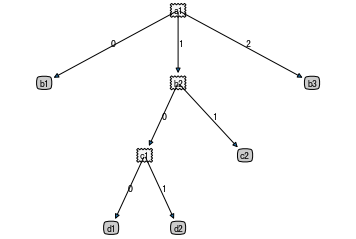

In [4]:
myTree = retrieveTree(2)
createPlot(myTree)

In [206]:
class TreeNode(object):
    def __init__(self, idx, data):
        self.idx = idx
        self.feature = self.val = None
        self.is_leaf = True
        
        self.posi = len(data[data[data.columns[-1]] == 1])
        self.nega = len(data[data[data.columns[-1]] == 0])

        self.ch = set()
        self.data = data
        
        if self.posi * 2.0 >= len(data):
            self.val = 1
        else:
            self.val = 0
            
class DecisionTree(object):
    
    def __init__(self, data, test_data):
        self.data = data
        self.test_data = test_data
        self.nodes = {}
        self.nodes[0] = TreeNode(0, self.data)
        self.nodes[0].is_leaf = True
        self.tot = 1
        self.n = len(data)
        self.tree = {}
        
    def add_node(self, data):
        self.nodes[self.tot] = TreeNode(self.tot, data)    
        self.tot += 1
        return self.tot - 1

    def Entropy(self, p1):
        if p1 < 1e-6 or p1 > 1.0 - 1e-6:
            return 0
        else:
            return -(p1 * math.log2(p1) + (1 - p1) * math.log2(1 - p1))
    
    def Gain(self, data, feature):
        import math
        p1 = len(data[data[data.columns[-1]] == 1]) / float(len(data))
        gain = self.Entropy(p1)
        groups = data.groupby(feature)
        for dat in groups:
            
            dat = dat[1]
            p1 = len(dat[dat[dat.columns[-1]] == 1]) / float(len(dat))
            gain -= len(dat) / float(len(data)) * self.Entropy(p1)
        return gain
    
    def Gini(self, data, feature):
        import math
        gini = 0.0
        groups = data.groupby(feature)
        for dat in groups:
            dat = dat[1]
            p1 = len(dat[dat[dat.columns[-1]] == 1]) / float(len(dat))
            gini += len(dat) / float(len(data)) * (1.0 - p1 * p1 - (1 - p1) * (1 - p1))
        return (1e9 - gini)
    
    def sel_feature(self, data, method = 0): 
        best_feature, max_gain = None, -1e9
        for feature in data.columns[:-1]:
            if method == 0:
                cur_gain = self.Gain(data, feature)
            elif method == 1:
                cur_gain = self.Gini(data, feature)
            else:
                cur_gain = random.randint(0, 1e9)
            if cur_gain > max_gain + 1e-6:
                best_feature, max_gain = feature, cur_gain
        return best_feature
    
    def to_end(self, data):
        if len(data) == 1:
            return True
        if len(data.groupby(data.columns[-1])) == 1:
            return True
        one_class = True
        for feature in data.columns[:-1]:
            if len(data.groupby(feature)) > 1:
                one_class = False
                break
        if one_class:
            return True
        return False        
    
    def prune_test(self, data, cur, feature, to_prune = True):
        feature_vals = set(data[feature].values)

        pre_accuracy = self.test_accuracy(self.test_data)
        
        self.nodes[cur].is_leaf = False  # for checking
        self.nodes[cur].feature = feature # for checking
        for (i, val) in enumerate(feature_vals):
            data_cur = data[data[feature] == val]
            nxt = self.add_node(data_cur)
         
            self.nodes[cur].ch.add((nxt, val))
        aft_accuracy = self.test_accuracy(self.test_data)
        
        print ('pre: {}, aft: {}'.format(pre_accuracy, aft_accuracy))
        if to_prune == True and pre_accuracy > aft_accuracy: # become not better
            self.nodes[cur].is_leaf = True # change back
            self.nodes[cur].feature = None # change back
            for (nxt, val) in self.nodes[cur].ch:
                self.nodes.pop(nxt)
                self.tot -= 1
            self.nodes[cur].ch.clear()
            return False
        else:
            return True
                
    def dfs(self, data, cur = 0, par = -1):
    
        if self.to_end(data) == True:
            print ('{} from {}, val is {}, end and return'.format(cur, par, self.nodes[cur].val))
            return
        
        feature = self.sel_feature(data)
        feature_vals = set(data[feature].values)
        if feature_vals == None or self.prune_test(data, cur, feature, True) == False:
            print ('{}: prune_test not pass!'.format(cur))
            return
        else:
            print ('{}: prune_test successfully pass!'.format(cur))
            
        for (nxt, val) in self.nodes[cur].ch:
            print ('dfs: ', nxt, val, self.nodes[nxt].posi, self.nodes[nxt].nega)
            self.dfs(self.nodes[nxt].data, nxt, cur)
        
    def get_tree(self, cur = 0):
        if self.nodes[cur].is_leaf == True:
            return self.nodes[cur].val
        else:
            cur_tree = {}
            for (nxt, val) in self.nodes[cur].ch:
                cur_tree[val] = self.get_tree(nxt)
            return {self.nodes[cur].feature: cur_tree}
    
    def train_accuracy(self):
        accuracy, n = 0.0, 0.0
        for cur in range(self.tot):
            if self.nodes[cur].is_leaf == True:
                n += self.nodes[cur].posi + self.nodes[cur].nega
                if self.nodes[cur].val == 1:
                    accuracy += self.nodes[cur].posi
                else:
                    accuracy += self.nodes[cur].nega
        return accuracy / float(n)
    
    def predict(self, sample, cur = 0):
        if self.nodes[cur].is_leaf == True:
            return ([cur],  self.nodes[cur].val)
        else:
            feature = self.nodes[cur].feature
            for (nxt, val) in self.nodes[cur].ch:
                next_data = self.nodes[nxt].data
                if len(next_data) > 0 and sample[feature] == next_data[feature].iloc[0]:
                    path, value = self.predict(sample, nxt)
                    return ([cur] + path, value)
            return ([cur], self.nodes[cur].val)
        
    def test_accuracy(self, test_data):
        accuracy, n = 0.0, len(test_data)
        for (i, sample) in enumerate(test_data.iterrows()):
            sample = sample[1]
            path, value = self.predict(sample, 0)
            if value == sample[-1]:
                accuracy += 1

        return accuracy / float(n)

## 4.3, 4.4

In [6]:
import random, math

def get_data2():
    data = pd.read_csv('./data2.csv')
    to_drop = list(set(['编号','密度', '含糖率']).intersection(data.columns))
    data = data.drop(axis=1,columns=to_drop)
    data['好瓜'] = data['好瓜'].apply(lambda x: 1 if x == '是' else 0)
    
    data = data.sample(frac = 1).reset_index(drop=True)
    data_posi = data[data.好瓜 == 1]
    data_nega = data[data.好瓜 == 0]
    data_train = data_posi[:int(len(data_posi)*0.7)].append(data_nega[:int(len(data_nega)*0.6)]).reset_index(drop=True)
    data_test = data_posi[int(len(data_posi)*0.7):].append(data_nega[int(len(data_nega)*0.6):]).reset_index(drop=True)

    return (data_train, data_test)

In [164]:
import random, math

def idxing(x):
    if x == 'Iris-setosa':
        return 2
    elif x == 'Iris-versicolor':
        return 0
    else:
        return 1
def rescaling(x, d1, d2):
    if (x <= d1):
        return 'small'
    elif (x <= d2):
        return 'mid'
    else:
        return 'big'
    
def get_data_iris():
    data = pd.read_csv('./data_iris.csv', names=['sepal_l', 'sepal_w', 'petal_l', 'petal_w', 'type'])

    data['type'] = data['type'].apply(idxing)
    data = data[data.type != 2]

    data_bar = np.apply_along_axis(axis=0,arr=data,func1d=np.median)
    for i in range(len(data_bar) - 1):
        feature = data.columns[i]
        sorted_feature_data = np.unique(sorted(list(data[feature])))
        n = len(sorted_feature_data)
        data[feature] = data[feature].apply(rescaling,d1=sorted_feature_data[n//3]
            ,d2=sorted_feature_data[2*n//3])

    data = data.sample(frac = 1).reset_index(drop=True)
    data_posi = data[data.type == 1].sample(frac = 1).reset_index(drop=True)
    data_nega = data[data.type == 0].sample(frac = 1).reset_index(drop=True)
    data_train = data_posi[:int(len(data_posi)*0.5)].append(data_nega[:int(len(data_nega)*0.5)]).reset_index(drop=True)
    data_test = data_posi[int(len(data_posi)*0.5):].append(data_nega[int(len(data_nega)*0.5):]).reset_index(drop=True)
    
    return (data_train, data_test)

In [214]:
(data_train, data_test) = get_data2()
print (len(np.where(data_train.好瓜==1)[0]), len(np.where(data_train.好瓜==0)[0]))
print (len(np.where(data_test.好瓜==1)[0]), len(np.where(data_test.好瓜==0)[0]))

5 5
3 4


In [191]:
(data_train, data_test) = get_data_iris()
print (len(np.where(data_train.type==1)[0]), len(np.where(data_train.type==0)[0]))
print (len(np.where(data_test.type==1)[0]), len(np.where(data_test.type==0)[0]))

25 25
25 25


pre: 0.42857142857142855, aft: 0.7142857142857143
0: prune_test successfully pass!
dfs:  3 清晰 5 1
pre: 0.7142857142857143, aft: 0.7142857142857143
3: prune_test successfully pass!
dfs:  5 硬滑 4 0
5 from 3, val is 1, end and return
dfs:  4 软粘 1 1
pre: 0.7142857142857143, aft: 0.7142857142857143
4: prune_test successfully pass!
dfs:  7 乌黑 0 1
7 from 4, val is 0, end and return
dfs:  6 青绿 1 0
6 from 4, val is 1, end and return
dfs:  1 模糊 0 3
1 from 0, val is 0, end and return
dfs:  2 稍糊 0 1
2 from 0, val is 0, end and return
train_accuracy: 1.0, test_accuracy: 0.7142857142857143


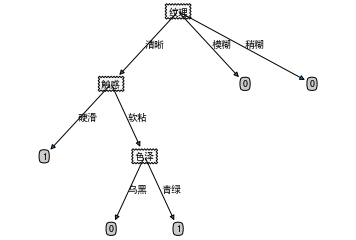

In [215]:
dt = DecisionTree(data_train, data_test)
dt.dfs(dt.data)
print ('train_accuracy: {}, test_accuracy: {}'.format(dt.train_accuracy(), dt.test_accuracy(dt.test_data)))

dt.tree = dt.get_tree()
if isinstance(dt.tree, dict):
    createPlot(dt.tree)